In [1]:
import pandas as pd
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from scipy import stats 

import missingno as msno 
plt.style.use('seaborn') 

import warnings 
warnings.filterwarnings("ignore") 

mpl.rcParams['axes.unicode_minus'] = False 

%matplotlib inline

from scipy.stats import norm
#Import & Data check
#기본적인 모듈 import

In [2]:
df_train = pd.read_csv("train.csv") 
df_test = pd.read_csv("test.csv")
submission=pd.read_csv('submission.csv')
data=df_train

<AxesSubplot:>

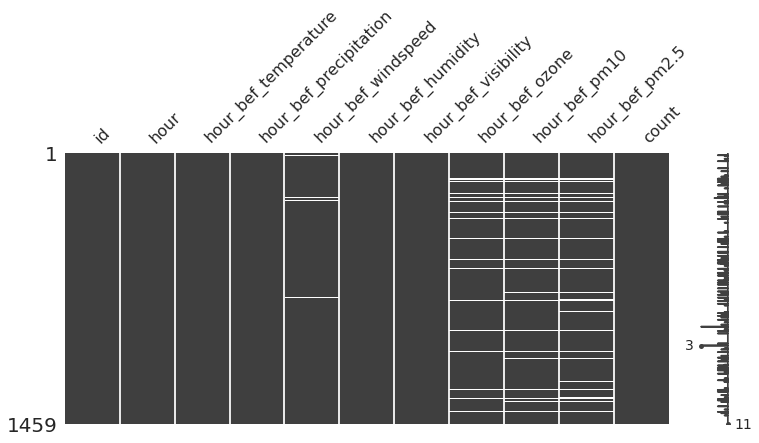

In [3]:
msno.matrix(df_train, figsize=(12,5)) 
#missingno의 matrix를 이용하여 시각화(결측값 확인)

In [4]:
# figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
# figure.set_size_inches(14,6)
# sns.distplot(data['count'], fit=norm, ax=ax1)
# sns.distplot(np.log(data['count']+1), fit=norm, ax=ax2)

<AxesSubplot:>

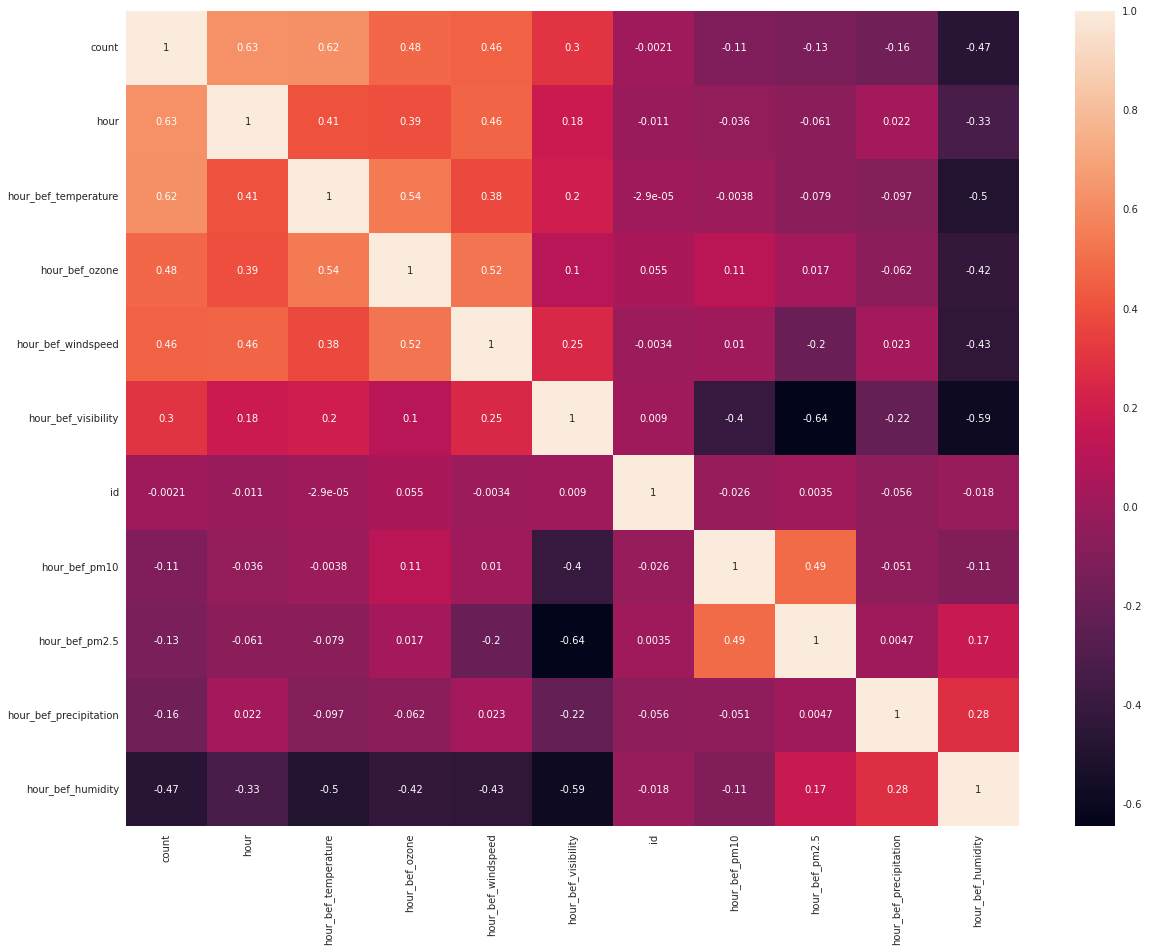

In [5]:
corr = df_train.corr()
top_corr = df_train[corr.nlargest(15,'count')['count'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

<AxesSubplot:xlabel='hour_bef_humidity', ylabel='count'>

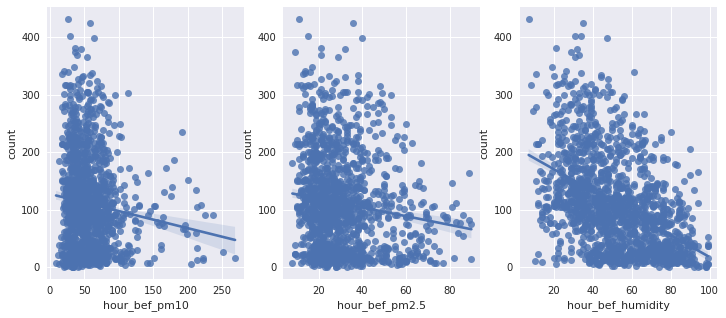

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(12,5))

temp_scatter_plot = pd.concat([df_train['count'],df_train['hour_bef_pm10']],axis = 1)
sns.regplot(x='hour_bef_pm10',y = 'count',data = temp_scatter_plot,scatter= True, fit_reg=True, ax=ax1) 

windspeed_scatter_plot = pd.concat([df_train['count'],df_train['hour_bef_pm2.5']],axis = 1) 
sns.regplot(x='hour_bef_pm2.5',y = 'count',data = windspeed_scatter_plot,scatter= True, fit_reg=True, ax=ax2) 

humidity_scatter_plot = pd.concat([df_train['count'],df_train['hour_bef_humidity']],axis = 1)
sns.regplot(x='hour_bef_humidity',y = 'count',data = humidity_scatter_plot,scatter= True, fit_reg=True, ax=ax3)

In [7]:
list(df_train)

['id',
 'hour',
 'hour_bef_temperature',
 'hour_bef_precipitation',
 'hour_bef_windspeed',
 'hour_bef_humidity',
 'hour_bef_visibility',
 'hour_bef_ozone',
 'hour_bef_pm10',
 'hour_bef_pm2.5',
 'count']

In [8]:
df_train_num = df_train.select_dtypes(exclude='object')
print('Numeric type columns:\n', df_train_num.columns)

Numeric type columns:
 Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')


In [9]:
df_train_num = df_train_num.fillna(df_train_num.mean())

# 결측치 평균으로 대체

In [10]:
df_train = df_train_num

In [11]:
from pycaret.regression import *

In [12]:
reg = setup(df_train, target='count', train_size=0.8)

,Description,Value
0,session_id,6987
1,Target,count
2,Original Data,"(1459, 11)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1167, 10)"


In [13]:
best_model = compare_models(sort = 'RMSE')
# 모델 비교의 경우 기본적으로 k-fold cv로 값을 비교하게 된다.(k=10)
# 본 과업에서의 평가지표는 'RMSE'이기 때문에 해당 지표를 기준으로 내림차순을 설정해 비교했다.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,25.0201,1366.0337,36.8039,0.7925,0.5038,0.8460,0.0850
lightgbm,Light Gradient Boosting Machine,25.6644,1400.2707,37.2986,0.7877,0.5254,0.7667,0.0150
rf,Random Forest Regressor,25.8400,1461.3082,38.0606,0.7787,0.5061,0.8128,0.1210
gbr,Gradient Boosting Regressor,27.0017,1525.4975,38.8185,0.7705,0.5303,0.8198,0.0340
ada,AdaBoost Regressor,40.8334,2488.1104,49.8122,0.6240,0.7998,1.6558,0.0210
dt,Decision Tree Regressor,33.6266,2655.3236,51.1587,0.5980,0.6455,0.7811,0.0060
lr,Linear Regression,38.8513,2672.5386,51.4756,0.5982,0.7655,1.1958,0.2180
lar,Least Angle Regression,38.8513,2672.5396,51.4756,0.5982,0.7655,1.1958,0.0040
ridge,Ridge Regression,38.8654,2682.2513,51.5779,0.5970,0.7525,1.1974,0.0040
br,Bayesian Ridge,38.9170,2699.3330,51.7534,0.5945,0.7584,1.2594,0.0050


In [14]:
et = create_model('et', cross_validation=False)
lightgbm = create_model('lightgbm', cross_validation=False)
rf = create_model('rf', cross_validation=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,28.0037,1670.2185,40.8683,0.772,0.5187,0.6626


In [15]:
tuned_et = tune_model(et, optimize='RMSE', n_iter=10)
tuned_lightgbm = tune_model(lightgbm, optimize='RMSE', n_iter=10)
tuned_rf = tune_model(rf, optimize='RMSE', n_iter=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,30.1060,1836.2859,42.8519,0.7574,0.8101,2.1048
1,32.3116,2182.6017,46.7183,0.7149,0.7031,1.6875
2,29.8001,1652.6074,40.6523,0.7141,0.6140,1.6452
3,30.4296,1823.5557,42.7031,0.6962,0.5042,0.5391
4,27.5675,1433.4945,37.8615,0.7835,0.6193,1.0796
5,29.3760,1748.1898,41.8114,0.7279,0.4857,0.5070
6,28.2021,1492.9168,38.6383,0.7446,0.4459,0.4638
7,28.5285,1840.3070,42.8988,0.7448,0.5553,0.6035
8,25.4912,1127.6302,33.5802,0.8154,0.5718,0.9116


In [16]:
blender_specific = blend_models(estimator_list = [tuned_et,tuned_lightgbm,tuned_rf])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,27.9577,1702.0387,41.2558,0.7751,0.7528,1.8538
1,31.2185,2059.2829,45.3793,0.7310,0.6951,1.7818
2,27.3835,1501.5715,38.7501,0.7402,0.5765,1.8593
3,29.0840,1867.0939,43.2099,0.6890,0.4679,0.4775
4,24.4264,1249.9391,35.3545,0.8112,0.5435,0.8441
5,27.3508,1486.1054,38.5500,0.7687,0.4500,0.4551
6,23.6078,1142.2296,33.7969,0.8046,0.3625,0.3435
7,25.9274,1583.4001,39.7920,0.7804,0.4776,0.4794
8,24.3484,1043.2351,32.2992,0.8292,0.5764,1.0327


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


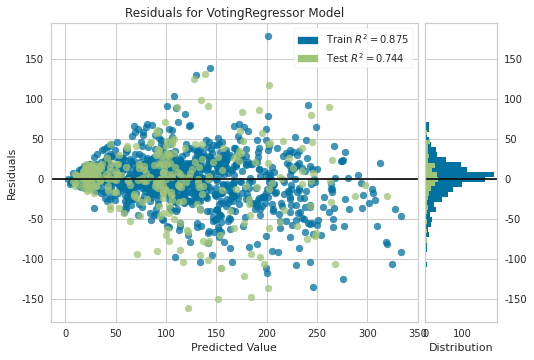

'\ntrain/test 유사분포\ntest set에 비해 train set 설명력이 매우 높은 것으로 보아 과적합을 의심해볼 수 있다.\ntrain/test 모두 아웃라이어 제거가 필요해보인다.\n'

In [17]:
# 시각화
# 모델 시각화(plot)

plot_model(blender_specific)

'''
train/test 유사분포
test set에 비해 train set 설명력이 매우 높은 것으로 보아 과적합을 의심해볼 수 있다.
train/test 모두 아웃라이어 제거가 필요해보인다.
'''

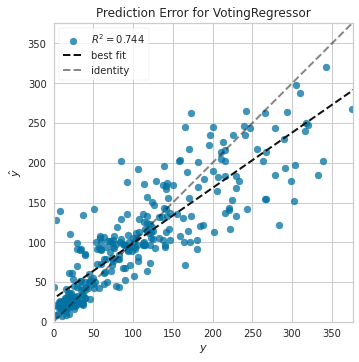

In [18]:
# 모델 시각화(plot)_plot = 'error'

plot_model(blender_specific, plot='error')

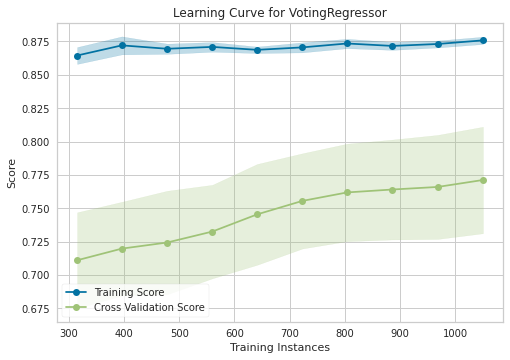

"\ntraining instances 1000회까지 cv가 상승 추세를 보아 어느정도 깊게 학습해도 일반화에 큰 무리가 없어보인다.\nscore = 'AUC' defalut 로 지정되어 있다.\n"

In [19]:
# 모델 시각화(plot)_plot = 'learning'

plot_model(blender_specific, plot='learning')

'''
training instances 1000회까지 cv가 상승 추세를 보아 어느정도 깊게 학습해도 일반화에 큰 무리가 없어보인다.
score = 'AUC' defalut 로 지정되어 있다.
'''

In [20]:
# 학습 및 예측
# 마지막 학습 및 예측(Finalize, Predict)

# 마지막 학습(Finalize)
final_model = finalize_model(blender_specific)

# 예측(Predict)
prediction = predict_model(final_model, data=df_test)

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 

In [21]:
print(prediction['Label'])

0       94.053232
1      211.630299
2       65.197683
3       56.775277
4       60.878884
          ...    
710     70.230530
711     59.067065
712    112.855006
713    158.021688
714    130.233380
Name: Label, Length: 715, dtype: float64


In [22]:
submission['count'] = prediction['Label']
print(submission[:10])
submission.to_csv('automl_ddareungi.csv')

   id       count
0   0   94.053232
1   1  211.630299
2   2   65.197683
3   4   56.775277
4   5   60.878884
5  10  141.540873
6  11  193.761402
7  12  252.586571
8  15   47.678934
9  17  111.399010
